In [1]:
import numpy as np
import torch
import open_clip
import csv
from tqdm import tqdm
import pandas
import matplotlib.pyplot as plt

/home/martin/Documents/MScProject/project_local/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
testsets = {
    "Progan" : ["progan_lsun"],
    "Biggan" : ["biggan_256","biggan_512"],
    "Gaugan" : ["gaugan"],
    "Stargan" : ["stargan"],
    "EG3D" : ["eg3d"],
    "Stylegan 2": ["stylegan2_afhqv2_512x512",
                   "stylegan2_ffhq_256x256",
                   "stylegan2_ffhq_1024x1024",
                   "stylegan2_lsundog_256x256",
                   "whichfaceisreal"],
    "Stylegan 3" : ["stylegan3_r_afhqv2_512x512",
                    "stylegan3_r_ffhqu_256x256",
                    "stylegan3_r_ffhqu_1024x1024",
                    "stylegan3_t_afhqv2_512x512",
                    "stylegan3_t_ffhqu_256x256",
                    "stylegan3_t_ffhqu_1024x1024"],
    "Taming Trans." : ["taming-transformers_class2image_ImageNet",
                             "taming-transformers_noise2image_FFHQ",
                             "taming-transformers_segm2image_valid"],
    "Dall-E Mini" : ["dalle-mini_valid"],
    "Dall-E 2" : ["dalle_2"],
    "Glide" : ["glide_text2img_valid"],
    "Guided Dif." : ["guided-diffusion_class2image_ImageNet",  
                "guided-diffusion_noise2image_LSUNbedrooms",
                "guided-diffusion_noise2image_LSUNcats",
                "guided-diffusion_noise2image_LSUNhorses"],
    "Latent Dif." : ["latent-diffusion_class2image_ImageNet",
                          "latent-diffusion_noise2image_FFHQ",
                          "latent-diffusion_noise2image_LSUNbedrooms",
                          "latent-diffusion_noise2image_LSUNchurches",
                          "latent-diffusion_text2img_valid"],
    "Stable Diff." : ["stable_diffusion_256"],
    "Stable Diff. v2" : ["stable_diffusion_512_50steps",
                             "stable_diffusion_512_100steps",
                             "stable_diffusion_512_200steps"],
    "DeepFakes" : ["deepfake"],
    "Pristine" : ["real_coco_valid", 
                  "real_imagenet_val", 
                  "real_ucid",
                  "ffhq",
                  "celebA",
                  ],
}

In [8]:
grag_accuracies = pandas.read_csv("data/grag_accuracies.csv", header=0, index_col=0)
vitL14_accuracies_datacomp_net = pandas.read_csv("data/stable-trained/vitL14_stable_100k_datacomp_net_accuracies.csv", header=0, index_col=0)
vitH14_accuracies_laion = pandas.read_csv("data/stable-trained/vitH14_stable_100k_laion_net_accuracies.csv", header=0, index_col=0)
vitL14_accuracies_openai_net = pandas.read_csv("data/stable-trained/vitL14_stable_100k_openai_net_accuracies.csv", header=0, index_col=0)
models = ["Grag_2021", "OpenAI LC", "Datacomp LC", "LAION LC"]
colors = {
    "Grag_2021" : 'blue',
    "OpenAI LC" : 'green',
    "Datacomp LC" : 'purple',
    "LAION LC" : "gray",
}

allsubmodels = []
for key in testsets:
    allsubmodels = allsubmodels + testsets[key]
tab_metrics = pandas.DataFrame(index=list(allsubmodels), columns = models)

for key in allsubmodels:
    tab_metrics.loc[key, "Grag_2021"] = grag_accuracies.loc[key, "Grag2021_latent"]
    tab_metrics.loc[key, "OpenAI LC"] = vitL14_accuracies_openai_net.loc[key + ".pt", "0.10"]
    tab_metrics.loc[key, "Datacomp LC"] = vitL14_accuracies_datacomp_net.loc[key + ".pt", "0.85"]
    tab_metrics.loc[key, "LAION LC"] = vitH14_accuracies_laion.loc[key + ".pt", "0.55"]

def plot_raw_accuracy(sets, models, width=0.30, multiplier=-1):
    plot_sets = sets
    plot_models = models

    x = np.arange(len(plot_sets))

    fig, ax = plt.subplots(layout='constrained')
    fig.set_size_inches(18.5, 3.0)

    for model in plot_models:
        measurement = []
        for set in plot_sets:
            subsets = testsets[set]
            m = np.mean([tab_metrics.loc[subset, model] for subset in subsets])
            measurement.append(m)
        measurement = tuple([m * 100 for m in measurement])
        offset = width * multiplier
        rects = ax.bar(x+offset, measurement, width, label=model, color=colors[model])
        multiplier += 1

    ax.set_ylabel("Accuracy")
    ax.set_xticks(x+width, plot_sets)
    ax.legend(loc='upper center', ncols=len(models))
    ax.set_ylim(0,115)
    ax.axhline(y = 100, color = 'black', linestyle = '-')

    plt.show()

def plot_mean_accuracy(sets, models, width=0.30, multiplier=-1):
    plot_sets = sets
    plot_models = models

    x = np.arange(len(plot_sets))

    fig, ax = plt.subplots(layout='constrained')
    fig.set_size_inches(18.5, 3.0)

    for model in plot_models:
        measurement = []
        for set in plot_sets:
            subsets = testsets[set]
            m = np.mean([tab_metrics.loc[subset, model] for subset in subsets])
            measurement.append(m)
        pristine_mean = np.mean([tab_metrics.loc[subset, model] for subset in testsets["Pristine"]])
        measurement = [(m+pristine_mean)/ 2 * 100 for m in measurement]
        GAN_accuracy = np.mean(measurement[0:7])
        VQGAN_accuracy = np.mean(measurement[7:9])
        DM_accuracy = np.mean(measurement[7:-2])
        mean_accuracy = np.mean(measurement[:-1])
        print(f"{model} : GAN({GAN_accuracy}) VQGAN({VQGAN_accuracy} DM({DM_accuracy}) MEAN({mean_accuracy})")
        measurement = tuple(measurement)
        offset = width * multiplier
        rects = ax.bar(x+offset, measurement, width, label=model, color = colors[model])
        ax.axhline(y = mean_accuracy, linestyle= ":", color=colors[model])
        multiplier += 1

    ax.set_ylabel("Accuracy")
    ax.set_xticks(x+width, plot_sets)
    ax.set_ylim(0,100)
    ax.axhline(y = 50, color = 'r', linestyle = '--')
    ax.axhline(y = 100, color = 'black', linestyle = '-')

    plt.show()

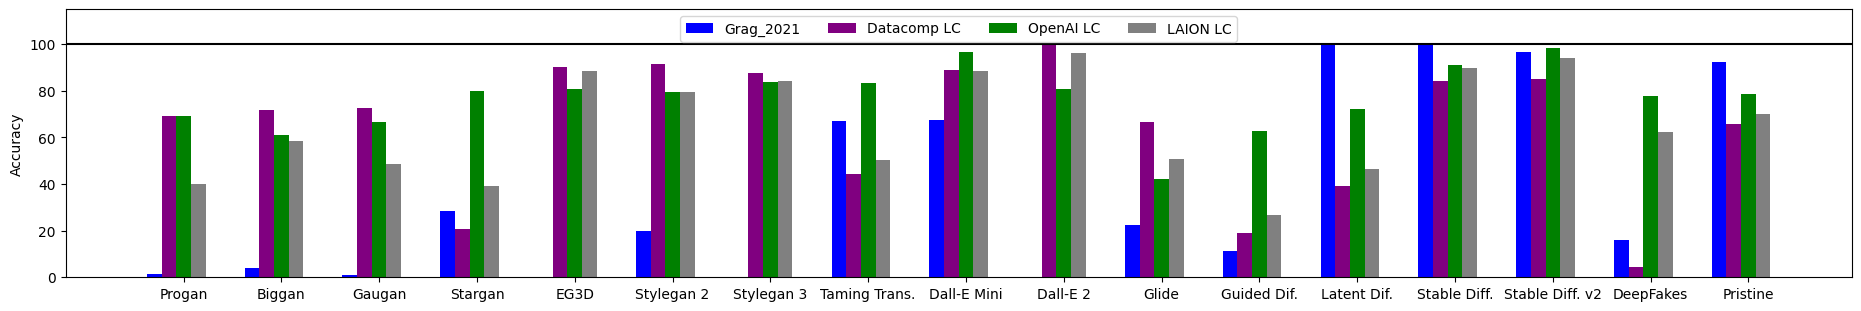

Grag_2021 : GAN(50.21630886872008) VQGAN(79.98481073870269 DM(72.61487026251221) MEAN(63.62187097715524)
Datacomp LC : GAN(68.87151706621164) VQGAN(66.1662093767362 DM(64.44704271006954) MEAN(67.24918629849142)
OpenAI LC : GAN(76.63650430499649) VQGAN(84.38373423782144 DM(77.16492471401192) MEAN(77.68124915805869)
LAION LC : GAN(66.26355483608333) VQGAN(69.65382639526041 DM(67.01281449049851) MEAN(67.6570052232)


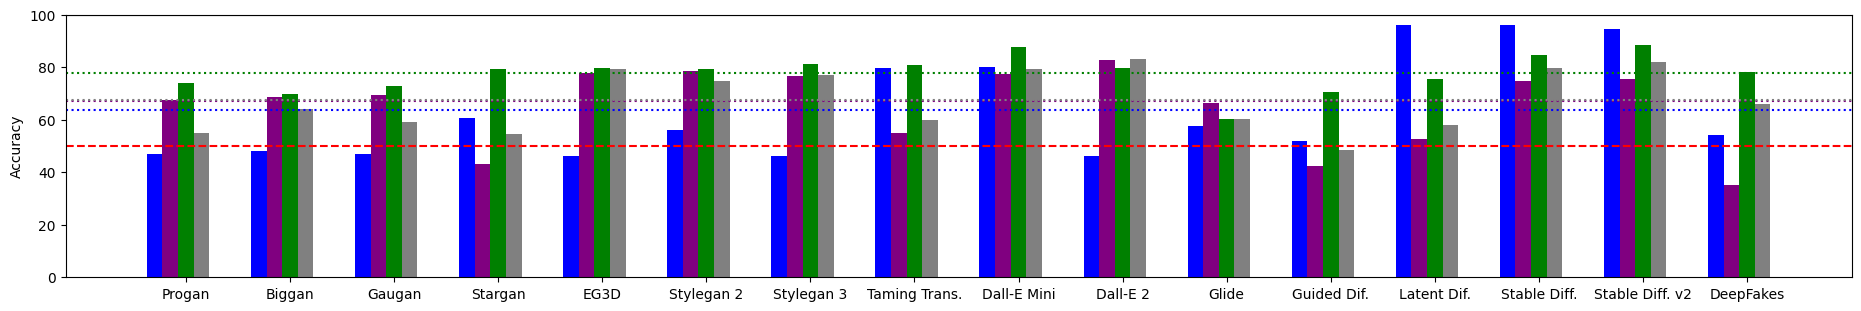

In [9]:
plot_sets = list(testsets.keys())
plot_models = ["Grag_2021", "Datacomp LC", "OpenAI LC", "LAION LC"]

plot_raw_accuracy(plot_sets, plot_models, width=0.15)

plot_sets = list(testsets.keys())[:-1]
plot_mean_accuracy(plot_sets, plot_models, width=0.15)